In [1]:
from collections import deque
import wave
import numpy as np
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

### Conversion

In [2]:
with wave.open('../sidegame/assets/sounds/rifle_t/ak47_01.wav', 'rb') as audio_stream:
    sound = np.frombuffer(audio_stream.readframes(audio_stream.getnframes()), dtype=np.int16).astype(np.float32)

left, right = sound[0::2], sound[1::2]

In [3]:
chunk_size = 1470
chunk_offset = 128

lchunks = deque()
rchunks = deque()

pleft, pright = np.pad(left, (128, 127)), np.pad(right, (128, 127))

while chunk_offset < len(pleft) - 256:
    lchunk = pleft[chunk_offset-128:chunk_offset+chunk_size+127]
    rchunk = pright[chunk_offset-128:chunk_offset+chunk_size+127]
    
    lchunks.append(lchunk)
    rchunks.append(rchunk)

    chunk_offset += chunk_size

lchunks[0] = np.pad(lchunks[0], (127, 0))
lchunks[-1] = np.pad(lchunks[-1], (0, 128))
rchunks[0] = np.pad(rchunks[0], (127, 0))
rchunks[-1] = np.pad(rchunks[-1], (0, 128))

lchunks = list(lchunks)
rchunks = list(rchunks)

In [4]:
len(lchunks), len(lchunks[0])

(86, 1852)

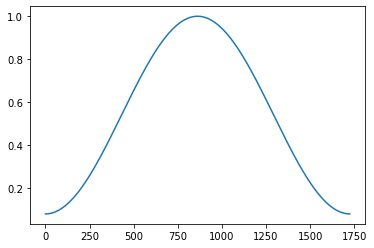

In [5]:
plt.plot(np.hamming(1470+255));

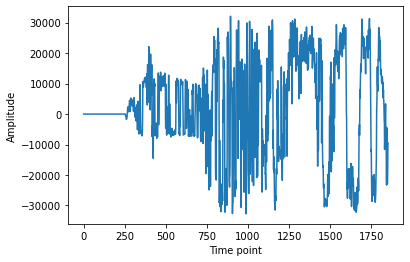

In [6]:
plt.plot(lchunks[0])
plt.xlabel('Time point')
plt.ylabel('Amplitude');

In [7]:
lchunks = [np.hamming(len(chunk))*chunk / 2**15 for chunk in lchunks]
rchunks = [np.hamming(len(chunk))*chunk / 2**15 for chunk in rchunks]

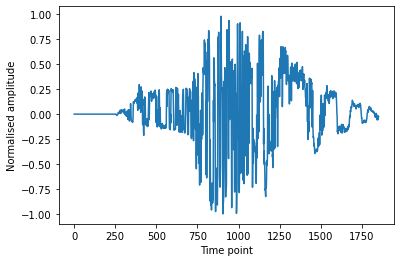

In [8]:
plt.plot(lchunks[0])
plt.xlabel('Time point')
plt.ylabel('Normalised amplitude');

In [9]:
def to_freq(x, n=2048):
    # NOTE: `n` needs to be a power of 2 for a fast algorithm to be used
    return np.power(np.abs(np.fft.rfft(x, n)), 2)

Validation with Parseval's theorem

In [10]:
np.sum(np.power(np.abs(lchunks[0]), 2))

179.01324630604256

In [11]:
np.sum(to_freq(lchunks[0], n=2048))*2/2048

180.7987530558947

In [12]:
np.sum(to_freq(lchunks[0], n=4096))*2/4096

179.90599968096862

#### Scaling?

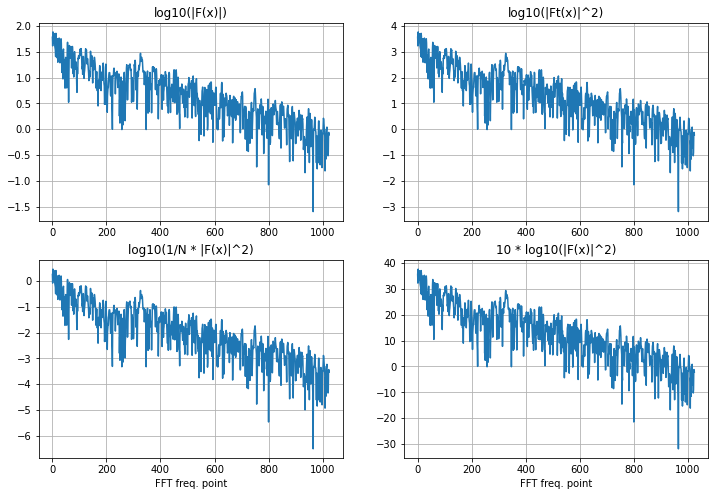

In [13]:
_, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0,0].plot(np.log10(np.sqrt(to_freq(lchunks[0], n=2048))))
axes[0,0].set_title('log10(|F(x)|)')
axes[0,0].grid()

axes[0,1].plot(np.log10(to_freq(lchunks[0], n=2048)))
axes[0,1].set_title('log10(|Ft(x)|^2)')
axes[0,1].grid()

axes[1,0].plot(np.log10(to_freq(lchunks[0], n=2048)/2048))
axes[1,0].set_title('log10(1/N * |F(x)|^2)')
axes[1,0].set_xlabel('FFT freq. point')
axes[1,0].grid()

axes[1,1].plot(10.*np.log10(to_freq(lchunks[0], n=2048)))
axes[1,1].set_title('10 * log10(|F(x)|^2)')
axes[1,1].set_xlabel('FFT freq. point')
axes[1,1].grid();

The answers on the internet don't give a conclusive answer, but it seems rather inconsequential, anyway.

For example, `pow(x, 2) / N` just scales the `log` output by `2` and offsets it by `log(N)`. Because normalisation of the input is something that is done in data pre-processing for machine learning in general, it seems unnecessary to put more focus on it here.

Standard `10*log10(|F(x)|^2)` is used for the remainder of this notebook.

### Visualisation

In [14]:
lfchunks = np.array([10.*np.log10(to_freq(chunk, 2048)) for chunk in lchunks])
rfchunks = np.array([10.*np.log10(to_freq(chunk, 2048)) for chunk in rchunks])

In [15]:
max(np.max(lfchunks), np.max(rfchunks)), min(np.min(lfchunks), np.min(rfchunks))

(41.884917298088766, -121.68979220357606)

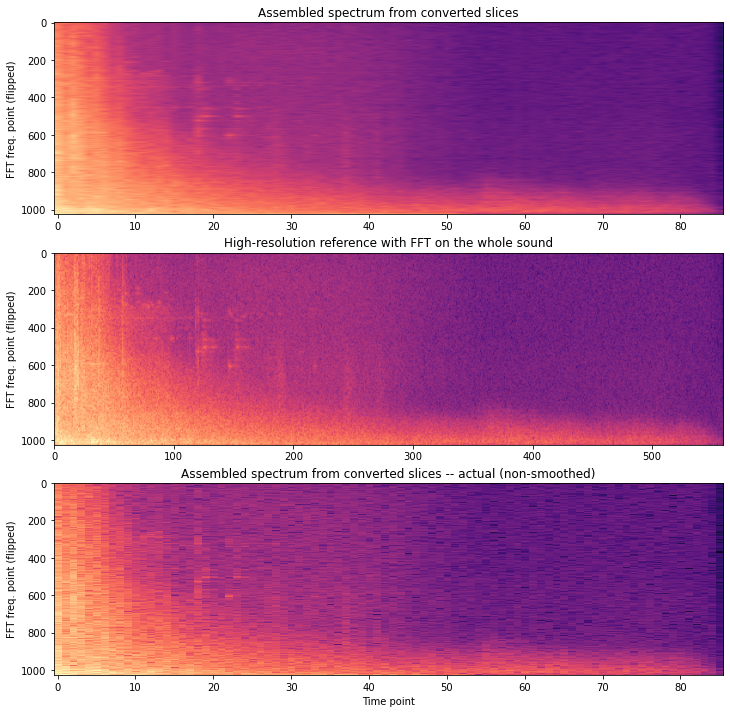

In [16]:
_, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

ax1.imshow(rfchunks.T[::-1], aspect='auto', cmap='magma', interpolation='bilinear')
ax1.set_title('Assembled spectrum from converted slices')
ax1.set_ylabel('FFT freq. point (flipped)')

ax2.imshow(10.*np.log10(spectrogram(right, 44100, nfft=2048)[2])[::-1], aspect='auto', cmap='magma')
ax2.set_title('High-resolution reference with FFT on the whole sound')
ax2.set_ylabel('FFT freq. point (flipped)')

ax3.imshow(rfchunks.T[::-1], aspect='auto', cmap='magma', interpolation='nearest')
ax3.set_title('Assembled spectrum from converted slices -- actual (non-smoothed)')
ax3.set_ylabel('FFT freq. point (flipped)')
ax3.set_xlabel('Time point');

### Logarithmic distribution of frequencies

References:
- https://en.wikipedia.org/wiki/Mel_scale
- https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
- https://librosa.org/doc/latest/generated/librosa.filters.mel.html#librosa.filters.mel

#### Mel filterbank

In [17]:
def mel(sampling_rate: int = 44100, n_fft: int = 2048, n_mel: int = 64):

    min_mel_freq = 0.
    max_mel_freq = 2595. * np.log10(1. + (sampling_rate/2.) / 700.)

    mel_freqs = np.linspace(min_mel_freq, max_mel_freq, n_mel + 2)
    hz_freqs = 700. * (10. ** (mel_freqs / 2595.) - 1.)
    fft_freqs = np.minimum(np.around((n_fft + 1) * hz_freqs / sampling_rate), float(n_fft//2))

    weights = np.zeros((n_mel, n_fft//2 + 1))

    # For each mel filter
    for i in range(1, n_mel + 1):
        freq_i_minus = int(fft_freqs[i - 1])
        freq_i = int(fft_freqs[i])
        freq_i_plus = int(fft_freqs[i + 1])

        # Construct left part of the triangular filter
        for freq_j in range(freq_i_minus, freq_i):
            weights[i - 1, freq_j] = (freq_j - fft_freqs[i - 1]) / (fft_freqs[i] - fft_freqs[i - 1])

        # Construct right part of the triangular filter
        for freq_j in range(freq_i, freq_i_plus + 1):
            weights[i - 1, freq_j] = (fft_freqs[i + 1] - freq_j) / (fft_freqs[i + 1] - fft_freqs[i])

    # Weights per filter should sum to 1 (const. area)
    return weights / np.sum(weights, axis=1)[:, None]

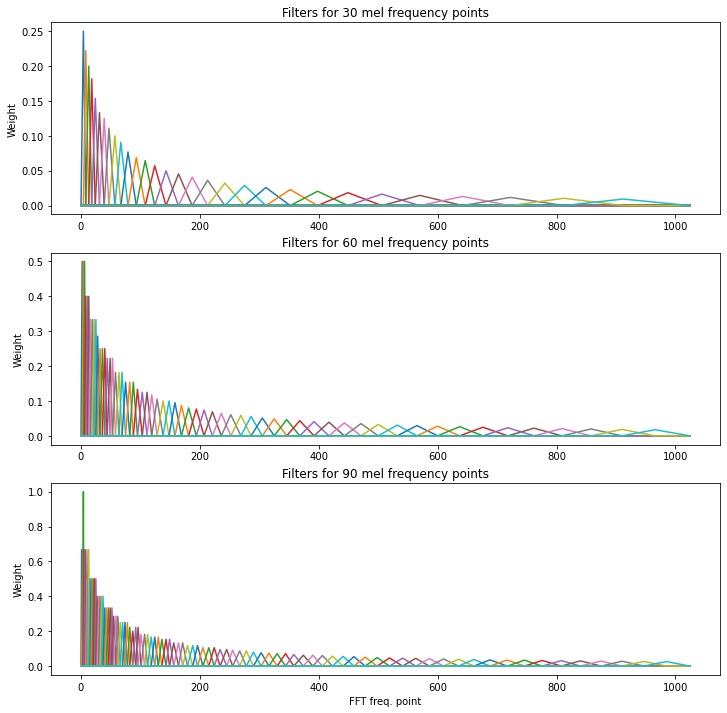

In [18]:
_, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

ax1.plot(mel(n_mel=30).T)
ax1.set_title('Filters for 30 mel frequency points')
ax1.set_ylabel('Weight')

ax2.plot(mel(n_mel=60).T)
ax2.set_title('Filters for 60 mel frequency points')
ax2.set_ylabel('Weight')

ax3.plot(mel(n_mel=90).T)
ax3.set_title('Filters for 90 mel frequency points')
ax3.set_ylabel('Weight')
ax3.set_xlabel('FFT freq. point');

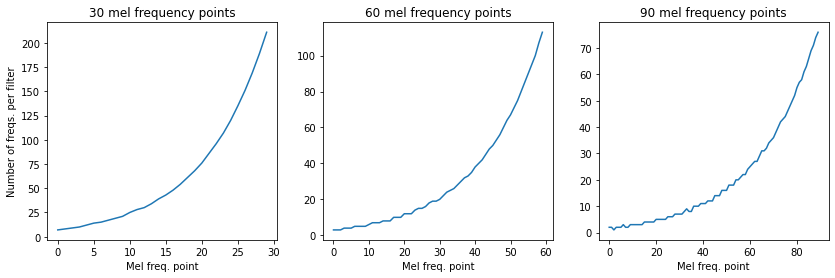

In [19]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

ax1.plot(np.sum(mel(n_mel=30) > 0., axis=1))
ax1.set_title('30 mel frequency points')
ax1.set_ylabel('Number of freqs. per filter')
ax1.set_xlabel('Mel freq. point')

ax2.plot(np.sum(mel(n_mel=60) > 0., axis=1))
ax2.set_title('60 mel frequency points')
ax2.set_xlabel('Mel freq. point')

ax3.plot(np.sum(mel(n_mel=90) > 0., axis=1))
ax3.set_title('90 mel frequency points')
ax3.set_xlabel('Mel freq. point');

Note: Filters can only extend to discrete sample points, i.e. some target frequencies will be comprised of more or fewer FFT frequencies, depending on how the samples align with the targets.

In the worst case, no samples will be available for some target frequency, making that value undetermined. The solution would be to use more sample points (`n_fft`) or fewer target frequencies (`n_mel`)

#### Application

In [20]:
lfchunks = np.array([to_freq(chunk, 2048) for chunk in lchunks])
rfchunks = np.array([to_freq(chunk, 2048) for chunk in rchunks])

In [21]:
mel_basis = mel(n_mel=64)

# NOTE: Might need to use numerically stable calls to `log10` (add `eps` or clip)
lfchunks = 10.*np.log10(np.dot(mel_basis, lfchunks.T))[::-1]
rfchunks = 10.*np.log10(np.dot(mel_basis, rfchunks.T))[::-1]

In [22]:
np.max(rfchunks), np.min(rfchunks)

(40.6174464609841, -90.66265945523247)

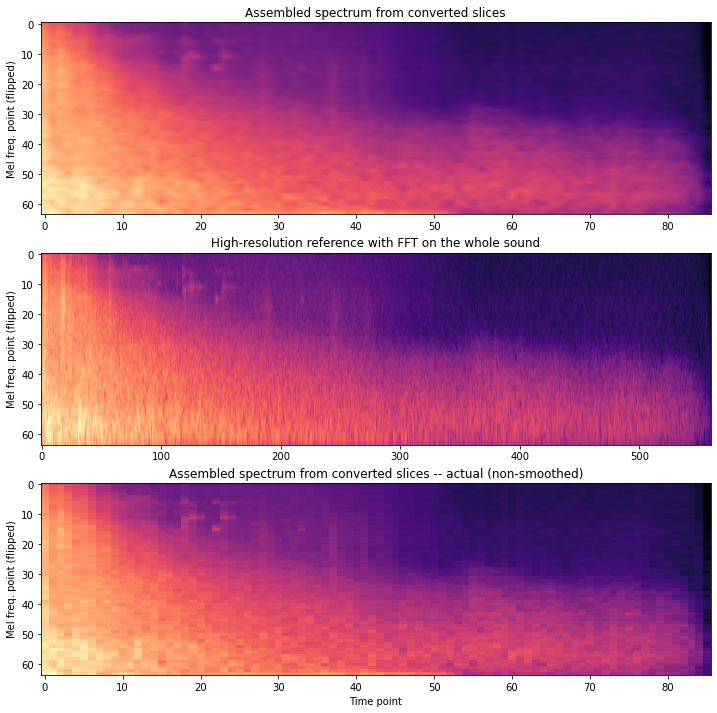

In [23]:
_, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

ax1.imshow(rfchunks, aspect='auto', cmap='magma', interpolation='bilinear')
ax1.set_title('Assembled spectrum from converted slices')
ax1.set_ylabel('Mel freq. point (flipped)')

ax2.imshow(10.*np.log10(np.dot(mel_basis, spectrogram(right, 44100, nfft=2048)[2]))[::-1], aspect='auto', cmap='magma')
ax2.set_title('High-resolution reference with FFT on the whole sound')
ax2.set_ylabel('Mel freq. point (flipped)')

ax3.imshow(rfchunks, aspect='auto', cmap='magma', interpolation='nearest')
ax3.set_title('Assembled spectrum from converted slices -- actual (non-smoothed)')
ax3.set_ylabel('Mel freq. point (flipped)')
ax3.set_xlabel('Time point');

### Discriminative ability for sequeunces of spectral vectors

#### Different source

In [24]:
with wave.open('../sidegame/assets/sounds/pistol_ct/usp_01.wav', 'rb') as audio_stream:
    sound2 = np.frombuffer(audio_stream.readframes(audio_stream.getnframes()), dtype=np.int16).astype(np.float32)

left2, right2 = sound2[0::2], sound2[1::2]

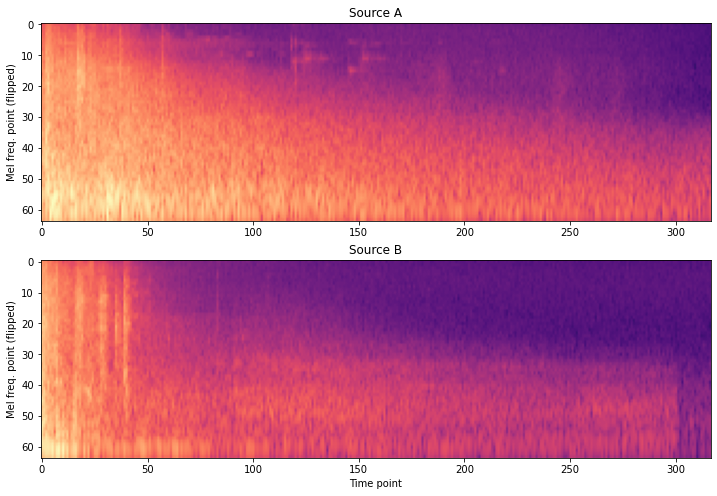

In [25]:
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

s1 = 10.*np.log10(np.dot(mel_basis, spectrogram(right, 44100, nfft=2048)[2]) + 1e-30)[::-1]
s2 = 10.*np.log10(np.dot(mel_basis, spectrogram(right2, 44100, nfft=2048)[2]) + 1e-30)[::-1]

minlen = min(s1.shape[1], s2.shape[1])
smin = -80
smax = max(np.max(s1), np.max(s2))

ax1.imshow(s1[:, :minlen], aspect='auto', cmap='magma', vmin=smin, vmax=smax)
ax1.set_title('Source A')
ax1.set_ylabel('Mel freq. point (flipped)')

ax2.imshow(s2[:, :minlen], aspect='auto', cmap='magma', vmin=smin, vmax=smax)
ax2.set_title('Source B')
ax2.set_ylabel('Mel freq. point (flipped)')
ax2.set_xlabel('Time point');

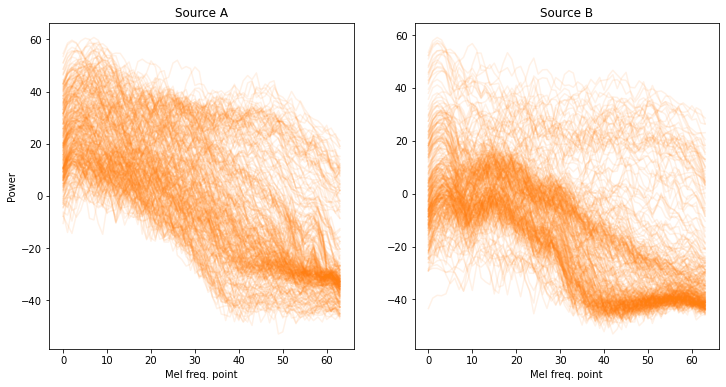

In [26]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for i in range(minlen):
    ax1.plot(s1[::-1, i], color='C1', alpha=0.1)
    
ax1.set_title('Source A')
ax1.set_xlabel('Mel freq. point')
ax1.set_ylabel('Power')

for i in range(minlen):
    ax2.plot(s2[::-1, i], color='C1', alpha=0.1)
    
ax2.set_title('Source B')
ax2.set_xlabel('Mel freq. point');

#### Different position of the same source

In [27]:
data = np.load('../sidegame/assets/hrir2d.npy')

Both ears, source on the left

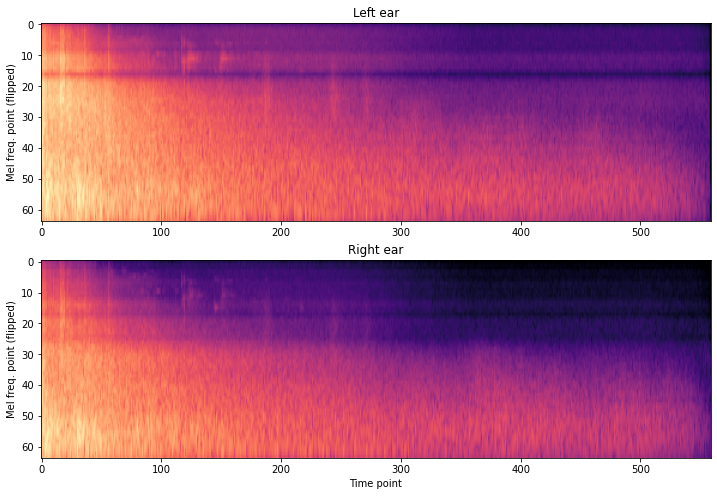

In [28]:
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

cleft = np.convolve(left, data[90//2,0], mode='valid')
cright = np.convolve(right, data[90//2,1], mode='valid')

s1 = 10.*np.log10(np.dot(mel_basis, spectrogram(cleft, 44100, nfft=2048)[2]) + 1e-30)[::-1]
s2 = 10.*np.log10(np.dot(mel_basis, spectrogram(cright, 44100, nfft=2048)[2]) + 1e-30)[::-1]

minlen = min(s1.shape[1], s2.shape[1])
smin = -80
smax = max(np.max(s1), np.max(s2))

ax1.imshow(s1[:, :minlen], aspect='auto', cmap='magma', vmin=smin, vmax=smax)
ax1.set_title('Left ear')
ax1.set_ylabel('Mel freq. point (flipped)')

ax2.imshow(s2[:, :minlen], aspect='auto', cmap='magma', vmin=smin, vmax=smax)
ax2.set_title('Right ear')
ax2.set_ylabel('Mel freq. point (flipped)')
ax2.set_xlabel('Time point');

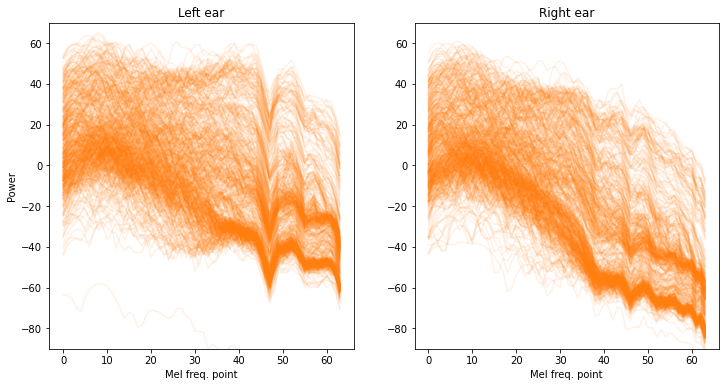

In [29]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for i in range(minlen):
    ax1.plot(s1[::-1, i], color='C1', alpha=0.1)
    
ax1.set_title('Left ear')
ax1.set_xlabel('Mel freq. point')
ax1.set_ylabel('Power')
ax1.set_ylim([-90, 70])

for i in range(minlen):
    ax2.plot(s2[::-1, i], color='C1', alpha=0.1)
    
ax2.set_title('Right ear')
ax2.set_xlabel('Mel freq. point')
ax2.set_ylim([-90, 70]);

Note: Interesting pronounced dip at around 8kHz.

In [30]:
# Converting target mel freq. point to Hz
700. * (10. ** (np.linspace(0., 2595. * np.log10(1. + (44100/2.) / 700.), 64 + 2)[48] / 2595.) - 1.)

8453.048271067146

Left ear, source in front vs source behind

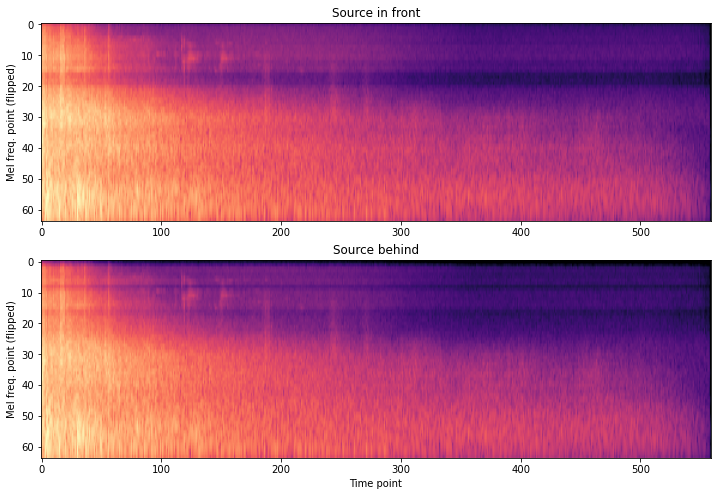

In [31]:
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

cfront = np.convolve(left, data[0,0], mode='valid')
cback = np.convolve(left, data[180//2,1], mode='valid')

s1 = 10.*np.log10(np.dot(mel_basis, spectrogram(cfront, 44100, nfft=2048)[2]) + 1e-30)[::-1]
s2 = 10.*np.log10(np.dot(mel_basis, spectrogram(cback, 44100, nfft=2048)[2]) + 1e-30)[::-1]

minlen = min(s1.shape[1], s2.shape[1])
smin = -80
smax = max(np.max(s1), np.max(s2))

ax1.imshow(s1[:, :minlen], aspect='auto', cmap='magma', vmin=smin, vmax=smax)
ax1.set_title('Source in front')
ax1.set_ylabel('Mel freq. point (flipped)')

ax2.imshow(s2[:, :minlen], aspect='auto', cmap='magma', vmin=smin, vmax=smax)
ax2.set_title('Source behind')
ax2.set_ylabel('Mel freq. point (flipped)')
ax2.set_xlabel('Time point');

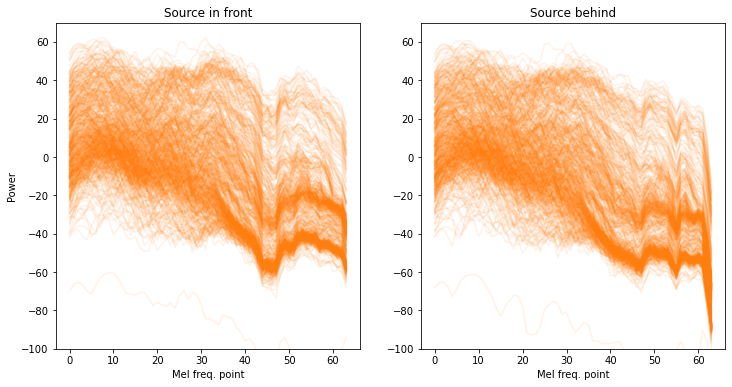

In [32]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for i in range(minlen):
    ax1.plot(s1[::-1, i], color='C1', alpha=0.1)
    
ax1.set_title('Source in front')
ax1.set_xlabel('Mel freq. point')
ax1.set_ylabel('Power')
ax1.set_ylim([-100, 70])

for i in range(minlen):
    ax2.plot(s2[::-1, i], color='C1', alpha=0.1)
    
ax2.set_title('Source behind')
ax2.set_xlabel('Mel freq. point')
ax2.set_ylim([-100, 70]);